# Laboratorio 3: Bases de datos vectoriales

En este ejercicio, exploraremos cómo aprovechar modelos de embedding para transformar datos textuales en representaciones vectoriales, almacenarlas en una base de datos vectorial y realizar búsquedas semánticas.
Antes de comenzar el laboratorio, estaremos usando GPU para el computo de los embeddings locales, por lo tanto, deben de ir a la seccion inferior de COLAB y cambiar el runtime a una GPU T4:
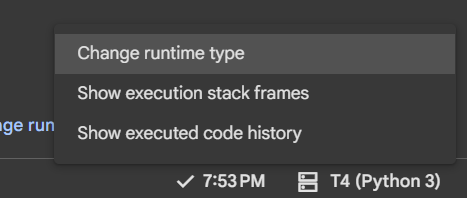

A lo largo de este laboratorio, realizarás las siguientes tareas:

1.  **Extracción de información de un archivo CSV**: Cargarás datos desde un archivo CSV.
2.  **Creación de embeddings**: Emplearás un modelo de embedding pre-entrenado para convertir la información en vectores (embeddings).
3.  **Almacenamiento en una BBDD vectorial**: Almacenarás los embeddings generados en un índice.
4.  **Búsquedas semánticas**: Realizarás búsquedas semánticas en el índice para encontrar información relevante.

# Pinecone

## Extracción de información de un archivo CSV

Carga el archivo home_depot_data.csv (https://www.kaggle.com/datasets/thedevastator/the-home-depot-products-dataset) en un DataFrame de pandas.

In [ ]:
import pandas as pd

df = pd.read_csv('home_depot_data.csv')
display(df.head())

,index,url,title,images,description,product_id,sku,gtin13,brand,price,currency,availability,uniq_id,scraped_at
0,0,https://www.homedepot.com/p/Carhartt-Men-s-3X-...,Men's 3X Large Carbon Heather Cotton/Polyester...,https://images.thdstatic.com/productImages/a7c...,"This heavyweight, water-repellent hooded sweat...",310090686,1.004455e+09,8.868595e+11,Carhartt,64.99,USD,InStock,ba6b9373-a145-5203-a7fe-5d9ede759dbb,2021-12-14 00:55:53.060268
1,1,https://www.homedepot.com/p/Turmode-30-ft-RP-T...,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,https://images.thdstatic.com/productImages/87a...,If you need more length between your existing ...,206724580,1.001661e+09,6.697163e+11,Unbranded,71.61,USD,InStock,70b7dd77-6474-5085-9afa-cda486a7237d,2021-12-14 00:55:53.070474
2,2,https://www.homedepot.com/p/Carolina-Pet-Compa...,Large Tapestry Bolster Bed,https://images.thdstatic.com/productImages/e6b...,Polyester cover resembling rich Italian tapest...,310347105,1.005202e+09,8.300001e+11,Carolina Pet Company,166.83,USD,InStock,8f573cae-947d-5262-8e51-b9381e8babeb,2021-12-14 00:55:53.677894
3,3,https://www.homedepot.com/p/16-Gauge-Sinks-Ves...,16-Gauge-Sinks Vessel Sink in White with Faucet,https://images.thdstatic.com/productImages/a6e...,It features a rectangle shape. This vessel set...,312338711,1.005103e+09,6.279872e+11,Unbranded,507.63,USD,InStock,3867081f-ea97-5855-8d6d-603b8e81f983,2021-12-14 00:55:53.987718
4,4,https://www.homedepot.com/p/Adtec-Men-s-Crazy-...,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,https://images.thdstatic.com/productImages/e7f...,This 9 in. black full grain leather logger boo...,308561619,1.004096e+09,6.477880e+11,Adtec,103.59,USD,InStock,e810513f-e5ed-598b-a17b-7ab60a1170fb,2021-12-14 00:55:54.003789


## Prepara los datos para la generación de embeddings

Selecciona las columnas de texto relevantes del DataFrame que serán utilizadas para generar los embeddings. En caso necesario, combina varias columnas (por ejemplo, nombre del producto y descripción) en un solo campo de texto.


In [ ]:
df['text_for_embedding'] = df['title'].fillna('') + ' ' + df['description'].fillna('')
display(df[['title', 'description', 'text_for_embedding']].head())

,title,description,text_for_embedding
0,Men's 3X Large Carbon Heather Cotton/Polyester...,"This heavyweight, water-repellent hooded sweat...",Men's 3X Large Carbon Heather Cotton/Polyester...
1,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,If you need more length between your existing ...,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...
2,Large Tapestry Bolster Bed,Polyester cover resembling rich Italian tapest...,Large Tapestry Bolster Bed Polyester cover res...
3,16-Gauge-Sinks Vessel Sink in White with Faucet,It features a rectangle shape. This vessel set...,16-Gauge-Sinks Vessel Sink in White with Fauce...
4,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...,This 9 in. black full grain leather logger boo...,Men's Crazy Horse 9'' Logger Boot - Steel Toe ...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('description').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('text_for_embedding').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['description'].value_counts()
    for x_label, grp in _df_3.groupby('title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('title')
_ = plt.ylabel('description')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text_for_embedding'].value_counts()
    for x_label, grp in _df_4.groupby('description')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('description')
_ = plt.ylabel('text_for_embedding')

## Cargado de modelo de embedding

Cargar el modelo de embeddings all-MiniLM-L6-v2 utilizando la librería sentence-transformers.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Definir una función que, dado un texto, retorne su vector de embeddings en forma de lista.

In [ ]:
def embed_text(text):
    embed = model.encode(text).tolist()
    return embed

## Creación del índice en Pinecone

En esta sección deberás establecer una conexión a tu cuenta de Pinecone utilizando tu API KEY. Para esto tendrás que crearte una cuenta en Pinecone (https://www.pinecone.io/).

Inicializar Pinecone utilizando la clave de API guardada en userdata.

In [ ]:
from pinecone import Pinecone
from google.colab import userdata

pc = Pinecone(api_key=userdata.get('pinecone_api_key'))

Crear un índice en Pinecone con la dimensión correspondiente al modelo y con la métrica cosine.

In [ ]:
from pinecone import ServerlessSpec

index_name = "products-index"
pc.create_index(
  name=index_name,
  dimension=model.get_sentence_embedding_dimension(),
  metric="cosine",
  spec=ServerlessSpec(
    cloud="aws",
    region="us-east-1"
  )
)

print(f"Index '{index_name}' created.")

## Cargado del índice

Implementa el código necesario para recorrer los datos del DataFrame, generar los embeddings correspondientes y realizar la inserción de la información en el índice creado previamente. Se debe utilizar un esquema de procesamiento por lotes para optimizar la carga.

In [ ]:
from tqdm.auto import tqdm

pinecone_index = pc.Index(index_name)

if pinecone_index:
    batch_size = 100
    data_to_upsert = []

    for row_index, row in tqdm(df.iterrows(), total=len(df)):
        doc_id = str(row['uniq_id'])
        text = row['text_for_embedding']
        embed = embed_text(text)
        metadata = {
            'title': row['title'],
            'url': row['url'],
            'description': row['description']
        }
        data_to_upsert.append({
            'id': doc_id,
            'values': embed,
            'metadata': metadata
        })

        # Upsert in batches
        if len(data_to_upsert) == batch_size:
            try:
                pinecone_index.upsert(vectors=data_to_upsert)
                data_to_upsert = [] # Clear the batch
            except Exception as e:
                print(f"Error during upsert: {e}")


    # Upsert any remaining data
    if data_to_upsert:
        try:
            pinecone_index.upsert(vectors=data_to_upsert)
        except Exception as e:
            print(f"Error during final upsert: {e}")

    print(f"Finished processing and upserting data.")
else:
    print("Pinecone index object is not available. Upsert operation skipped.")

## Verificación de datos en el índice

Verifica las estadísticas del índice para asegurarte de que los datos se hayan cargado correctamente.

In [ ]:
index_stats = pinecone_index.describe_index_stats()
print(index_stats)

## Búsqueda semántica

Realiza consultas al índice utilizando consultas del estilo "best tool for repairing walls" y muestra los resultados obtenidos.

In [ ]:
query = "best tool for repairing walls"
query_embedding = embed_text(query)

try:
    search_results = pinecone_index.query(vector=query_embedding, top_k=5, include_metadata=True)
    print(f"\nSemantic search results for query: '{query}'")
    for match in search_results['matches']:
        print(f"ID: {match['id']}, Score: {match['score']:.4f}")
        if 'metadata' in match:
            print(f"  Title: {match['metadata'].get('title', 'N/A')}")
            print(f"  URL: {match['metadata'].get('url', 'N/A')}")
        print("-" * 20)
except Exception as e:
    print(f"Error during semantic search: {e}")

# FAISS
Realiza una práctica de búsqueda semántica utilizando FAISS y un dataset del sitio web https://www.kaggle.com/datasets.

## Cargar el nuevo dataset

Carga el archivo en un DataFrame de pandas.


In [ ]:
import pandas as pd

df_movies = pd.read_csv(
    "wiki_movies_data.csv",
    sep=",",
    quotechar='"',
    engine="python",
    on_bad_lines="skip",   # skip any rows that blow up
    encoding="utf-8"
)

print(df_movies.shape)
print(df_movies.head())


(34886, 8)
   Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast    Genre  \
0                             Unknown  NaN  unknown   
1                             Unknown  NaN  unknown   
2                             Unknown  NaN  unknown   
3                             Unknown  NaN  unknown   
4  George S. Fleming, Edwin S. Porter  NaN  unknown   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en

## Preparar los datos para la generación de embeddings

Selecciona las columnas de texto relevantes del nuevo DataFrame que serán utilizadas para generar los embeddings. Combina las columnas necesarias en un solo campo de texto.


In [ ]:
df_movies['text_for_embedding_movies'] = df_movies['Title'].fillna('') + ' ' + \
                                         df_movies['Director'].fillna('') + ' ' + \
                                         df_movies['Cast'].fillna('') + ' ' + \
                                         df_movies['Genre'].fillna('') + ' ' + \
                                         df_movies['Plot'].fillna('')

display(df_movies[['Title', 'Director', 'Cast', 'Genre', 'Plot', 'text_for_embedding_movies']].head())

,Title,Director,Cast,Genre,Plot,text_for_embedding_movies
0,Kansas Saloon Smashers,Unknown,NaN,unknown,"A bartender is working at a saloon, serving dr...",Kansas Saloon Smashers Unknown unknown A bart...
1,Love by the Light of the Moon,Unknown,NaN,unknown,"The moon, painted with a smiling face hangs ov...",Love by the Light of the Moon Unknown unknown...
2,The Martyred Presidents,Unknown,NaN,unknown,"The film, just over a minute long, is composed...",The Martyred Presidents Unknown unknown The f...
3,"Terrible Teddy, the Grizzly King",Unknown,NaN,unknown,Lasting just 61 seconds and consisting of two ...,"Terrible Teddy, the Grizzly King Unknown unkn..."
4,Jack and the Beanstalk,"George S. Fleming, Edwin S. Porter",NaN,unknown,The earliest known adaptation of the classic f...,"Jack and the Beanstalk George S. Fleming, Edwi..."


## Generar embeddings

Aplica la función para generar los embeddings para el texto preparado en el paso anterior.


In [ ]:
# Collect all texts
texts = df_movies['text_for_embedding_movies'].tolist()

# Encode on GPU with batching
movie_embeddings = model.encode(
    texts,
    batch_size=128,          # adjust if you run out of memory
    show_progress_bar=True,
    convert_to_numpy=True,
    device="cuda"            # force GPU usage
)

print(f"Generated embeddings for {len(movie_embeddings)} movies "
      f"with dimension {movie_embeddings.shape[1]}.")


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

Generated embeddings for 34886 movies with dimension 384.


## Crear un índice FAISS

Inicializa un índice FAISS con la dimensión correcta para los embeddings generados.

In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss

embedding_dimension = movie_embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dimension)

print(f"FAISS index created with dimension {embedding_dimension}.")

FAISS index created with dimension 384.


## Agregar embeddings al índice FAISS

Agrega los embeddings generados al índice FAISS.

In [ ]:
index.add(movie_embeddings)

print(f"Added {index.ntotal} embeddings to the FAISS index.")

Added 34886 embeddings to the FAISS index.


## Realizar búsquedas semánticas en FAISS

Realiza consultas al índice FAISS utilizando consultas de texto y muestra los resultados obtenidos.

In [ ]:
def search_faiss(query_text, index, model, df, top_k=5):
    query_embedding = model.encode(query_text).reshape(1, -1)
    distances, indices = index.search(query_embedding, top_k)

    print(f"\nSemantic search results for query: '{query_text}'")
    for i in range(top_k):
        movie_index = indices[0][i]
        distance = distances[0][i]
        movie_info = df.iloc[movie_index]
        print(f"Rank {i+1}: Distance: {distance:.4f}")
        print(f"  Title: {movie_info['Title']}")
        print(f"  Plot: {movie_info['Plot']}")
        print("-" * 20)

search_faiss("A space opera with lightsabers and Jedi knights", index, model, df_movies)


Semantic search results for query: 'A space opera with lightsabers and Jedi knights'
Rank 1: Distance: 1.2483
  Title: Bravestarr: The Legend
  Plot: Far out in space on New Texas, a single marshal protects a frontier people from the evil machinations of Stampede and his lackey, Tex Hex.
--------------------
Rank 2: Distance: 1.3208
  Title: Space Ship Sappy
  Plot: The Stooges meet up with eccentric Professor A.K. Rimple (Benny Rubin) and his daughter (Doreen Woodbury) who ask the trio to help them with a space mission. The mission lands on the planet Sunev (Venus spelled backwards), where the Stooges are taken in by three attractive female aliens. At first, sparks fly (literally) when the girls kiss the boys. But then the ladies turn cannibalistic, and are about the suck the Stooges' blood. However, the boys are able to escape, as a huge lizard appears on the horizon, causing the women to run away. The three jump back in the rocket ship, knocking the Professor and his daughter out c